In [4]:
import numpy as np
import pandas as pd
import pickle
#from build_database import flux_obj
from scipy import interpolate
import matplotlib.pyplot as plt
import os
import itertools
import random
import os
import time
import datetime
import gzip
import scipy.io
import matplotlib.gridspec as gridspec

from mpl_toolkits.basemap import Basemap
from spacepy import coordinates as coord
from spacepy.time import Ticktock as Ticktock

from mpl_toolkits.mplot3d import Axes3D

%matplotlib notebook
# %matplotlib nbagg
# Autoload changes made in external editor:
%load_ext autoreload
%autoreload 2
# --------------- Latex Plot Beautification --------------------------
fig_width = 12 
fig_height = 12
fig_size =  [fig_width+1,fig_height+1]
params = {'backend': 'ps',
          'axes.labelsize': 14,
          'font.size': 14,
          'legend.fontsize': 14,
          'xtick.labelsize': 14,
          'ytick.labelsize': 14,
          'text.usetex': False,
          'figure.figsize': fig_size}
plt.rcParams.update(params)
# --------------- Latex Plot Beautification --------------------------

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
# Constants:

Zo = 377.
mu = 4.*np.pi*1e-7
a = 5*1e3
b = 1*1e5
H_E = 5000   # meters
R_E = 6371e3 # meters
H_IONO_BOT = 100e3 # 100 km
R2D = 180./np.pi
D2R = np.pi/180.

In [119]:
# Total radiated energy:

Io = -10.53e3   # to match Dave's stuff
total_energy = (1/Zo)*pow(mu/2./np.pi, 2)*(pow((a - b),2)/2/(a + b))* (4.*np.pi/3.)*pow(H_E*Io,2)*1e-3

print "Total energy from discharge: %g kJ"%total_energy # Should be 52.94 kJ

Total energy from discharge: 52.9458 kJ


In [266]:
def input_power(inp_lat, inp_lon, out_lat, out_lon, w, Io, MLT):
    D2R = np.pi/180.
    R2D = 180./np.pi
    Z0 = 377.0
    P_A= 5.0e3
    P_B= 1.0e5
    H_E= 5000.0
    mu0= 4.0*np.pi*1e-7
    H_IONO_BOT = 1.0e5
    R_E = 6371e3
    
#     f = w/(2.0*np.pi)
    
    dlat  = D2R*(out_lat - inp_lat) # separation in latitude (radians)
    dlong = D2R*(out_lon - inp_lon) # separation in longitude (radians)
    clat1 = np.cos(D2R*inp_lat) 
    clat2 = np.cos(D2R*out_lat)
    slat1 = np.sin(D2R*inp_lat)
    slat2 = np.sin(D2R*out_lat)
    # Compute current (latitude and longitude dependent) weighting:
    # (Use Haversine formula since we're moving further out than reasonable for Cartesian)
    ha = pow(np.sin(dlat/2.0),2)
    hb = (clat1*clat2*pow(np.sin(dlong/2.0),2))
    gc_distance = 2.0*R_E * np.arcsin(np.sqrt(ha + hb))  # Distance along ground GCP, in meters
    gc_distance = np.clip(gc_distance, 100, None)
    
    dist_tot= np.hypot(gc_distance, H_IONO_BOT) # Lengthened path up to the ionosphere (the hypotenuse of the triangle)
    
    # Angle from vertical to direction: (trend towards 90deg for large distances)
    # (Zenith angle)
    xi = np.arctan2(gc_distance, H_IONO_BOT)

    frontmatter = (1/Z0)*pow(mu0*H_E*Io/2./np.pi, 2)

    
    if w is None:
        freq_terms = (pow((P_A - P_B),2)/2./(P_A + P_B))  # Integrated over all frequencies
    else:
        w_sq = w*w        
        freq_terms = w_sq*pow(P_A - P_B,2)/(w_sq + pow(P_A,2))/(w_sq + pow(P_B,2))/np.pi
    position_terms = pow(np.sin(xi)/dist_tot, 2)
    
    vert_term = np.cos(xi)
    # S has units of J/m^2/Hz  (or J/m^2 if you're using the integrated freq_term)
    S = frontmatter*freq_terms*position_terms*vert_term
    
    return S

# input_power(0,0,0.5,0,200*2.*np.pi,-10e3,0)

dlat = 0.01 
dlon = 0.01
dfreq = 1000
extent = 5
lats = np.arange(-extent, extent, dlat)
lons = np.arange(-extent, extent, dlon)
freqs = np.arange(100, 100000, dfreq)

Io = -10e3


data = np.zeros([len(lons), len(lats)])
cell_areas = np.zeros_like(data)


for lat_ind, lat in enumerate(lats):
    
    data[:, lat_ind] = input_power(0,0,lat,lons, None, Io, 0)
    dist_lat = (R_E + H_IONO_BOT)*dlat*D2R
    dist_lon = (R_E + H_IONO_BOT)*dlon*D2R*np.cos((lat + dlat/2.)*D2R)
    cell_areas[:, lat_ind] = dist_lat*dist_lon
    

# Attempt to integrate this:

integ = np.sum(np.sum(data*cell_areas))

print "total energy (grid method): %g kJ"%(integ*1e-3)

def integrand(outlat, outlon, f):
    
    if f is None:
        pwr = input_power(0, 0, outlat, outlon, None, Io, 0)
    else:
        pwr = input_power(0, 0, outlat, outlon, 2.*np.pi*f, Io, 0)
    return pwr*pow((R_E + H_IONO_BOT)*D2R, 2)*np.cos(outlat*D2R)

tot = 0
integ = nquad(integrand, [[-extent,extent],[-extent,extent]], args =[None])
tot += integ[0]
print "total energy (nquad method): %g kJ"%(tot*1e-3)





total energy (grid method): 37.5427 kJ
total energy (nquad method): 37.5427 kJ


In [273]:
from scipy.integrate import nquad
# Io = -100.e3

# Integrator params
opts = dict()
opts['epsabs']= 1.5e-4
opts['epsrel']= 1.5e-4
opts['limit']= 2

flogs = np.linspace(np.log10(50), np.log10(500000),65)
freqs = pow(10, flogs)
fdifs = np.diff(freqs)  # Bin widths (hz)
fcents = (freqs[0:-1] + freqs[1:])/2. # Center frequencies (hz)

def integrand(outlat, outlon, f):
    
    pwr = input_power(0, 0, outlat, outlon, f*2.*np.pi, Io, 0)
    return pwr*pow((R_E + H_IONO_BOT)*D2R, 2)*np.cos(outlat*D2R)

tot = 0
for f_ind, f in enumerate(fcents):
    integ = nquad(integrand, [[-extent,extent],[-extent,extent]], args =[f])
    tot += integ[0]*fdifs[f_ind]*2.*np.pi
    print "%g: %g kJ"%(f,integ[0]*1e-3)
# target: 43.44945 kJ

print "total:", tot*1e-3
# print integ[0]*1e-3

53.8695: 1.14475e-06 kJ
62.2076: 1.52423e-06 kJ
71.8362: 2.02847e-06 kJ
82.9551: 2.69771e-06 kJ
95.7951: 3.58458e-06 kJ
110.622: 4.75739e-06 kJ
127.745: 6.30411e-06 kJ
147.517: 8.33664e-06 kJ
170.35: 1.09949e-05 kJ
196.718: 1.44502e-05 kJ
227.166: 1.89056e-05 kJ
262.327: 2.45913e-05 kJ
302.931: 3.17521e-05 kJ
349.819: 4.06221e-05 kJ
403.965: 5.13862e-05 kJ
466.491: 6.41276e-05 kJ
538.695: 7.87719e-05 kJ
622.076: 9.50426e-05 kJ
718.362: 0.000112451 kJ
829.551: 0.000130336 kJ
957.951: 0.000147952 kJ
1106.22: 0.000164581 kJ
1277.45: 0.000179639 kJ
1475.17: 0.000192732 kJ
1703.5: 0.000203668 kJ
1967.18: 0.000212418 kJ
2271.66: 0.000219062 kJ
2623.27: 0.000223729 kJ
3029.31: 0.000226548 kJ
3498.19: 0.000227611 kJ
4039.65: 0.000226959 kJ
4664.91: 0.000224566 kJ
5386.95: 0.000220351 kJ
6220.76: 0.000214192 kJ
7183.62: 0.000205954 kJ
8295.51: 0.000195543 kJ
9579.51: 0.000182954 kJ
11062.2: 0.000168337 kJ
12774.5: 0.000152037 kJ
14751.7: 0.000134595 kJ
17035: 0.000116706 kJ
19671.8: 9.91185e-05

In [279]:
# here's how to do the triple integral totally with nquad (in frequency steps):
def integrand(outlat, outlon, f):
    
    pwr = input_power(0, 0, outlat, outlon, f*2.*np.pi, Io, 0)
    return pwr*pow((R_E + H_IONO_BOT)*D2R, 2)*np.cos(outlat*D2R)

tot = 0
for f_ind, f in enumerate(fcents):
    integ = nquad(integrand, [[-extent,extent],[-extent,extent],[freqs[f_ind], freqs[f_ind+1]]])
    tot += integ[0]*2.*np.pi
    print "%g: %g kJ"%(f,(integ[0]*1e-3))
print "total:", tot*1e-3


# target: 43.44945 kJ

53.8695: 1.41238e-06 kJ
62.2076: 2.17162e-06 kJ
71.8362: 3.3373e-06 kJ
82.9551: 5.12523e-06 kJ
95.7951: 7.86397e-06 kJ
110.622: 1.20519e-05 kJ
127.745: 1.84412e-05 kJ
147.517: 2.81596e-05 kJ
170.35: 4.28836e-05 kJ
196.718: 6.50769e-05 kJ
227.166: 9.83066e-05 kJ
262.327: 0.000147639 kJ
302.931: 0.000220092 kJ
349.819: 0.000325081 kJ
403.965: 0.000474747 kJ
466.491: 0.000683976 kJ
538.695: 0.000969946 kJ
622.076: 0.0013511 kJ
718.362: 0.00184562 kJ
829.551: 0.00246992 kJ
957.951: 0.00323748 kJ
1106.22: 0.00415877 kJ
1277.45: 0.00524212 kJ
1475.17: 0.00649529 kJ
1703.5: 0.00792707 kJ
1967.18: 0.00954835 kJ
2271.66: 0.0113723 kJ
2623.27: 0.0134135 kJ
3029.31: 0.0156858 kJ
3498.19: 0.0181998 kJ
4039.65: 0.0209573 kJ
4664.91: 0.0239467 kJ
5386.95: 0.0271348 kJ
6220.76: 0.0304596 kJ
7183.62: 0.0338226 kJ
8295.51: 0.0370854 kJ
9579.51: 0.0400723 kJ
11062.2: 0.0425841 kJ
12774.5: 0.0444234 kJ
14751.7: 0.0454278 kJ
17035: 0.0455037 kJ
19671.8: 0.0446476 kJ
22716.6: 0.0429466 kJ
26232.7: 0.040559

In [ ]:
# And all in one go (3d nquad)
def integrand(outlat, outlon, f):
    
    pwr = input_power(0, 0, outlat, outlon, f*2.*np.pi, Io, 0)
    return pwr*pow((R_E + H_IONO_BOT)*D2R, 2)*np.cos(outlat*D2R)

tot = 0
# for f_ind, f in enumerate(fcents):
    integ = nquad(integrand, [[-extent,extent],[-extent,extent],[freqs[0], freqs[-1]]])
#     tot += integ[0]*2.*np.pi
print "%g: %g kJ"%(f,(2.*np.pi*integ[0]*1e-3))



# target: 43.44945 kJ

In [281]:
print "total:", 2.*np.pi*tot*1e-3



total: 36.744090154


<IPython.core.display.Javascript object>


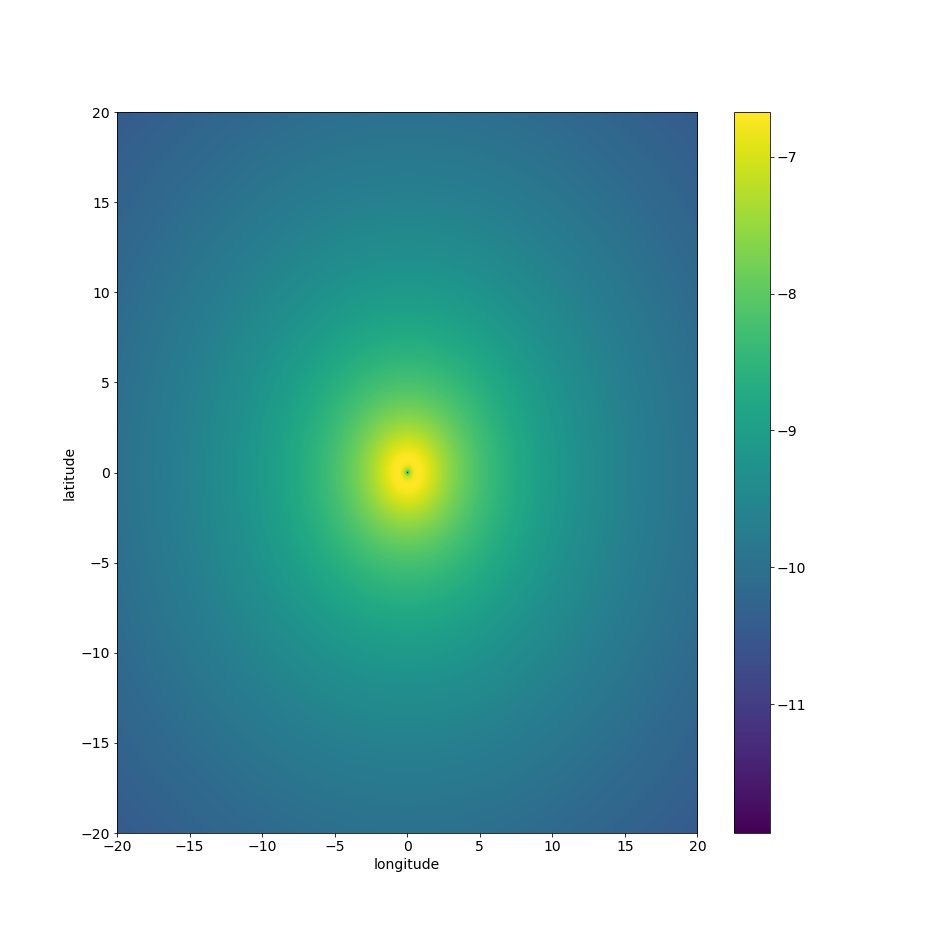

In [264]:
fig, ax = plt.subplots(1,1)
p = ax.pcolorfast(lats, lons, np.log10(data.T))
fig.colorbar(p)
ax.set_ylabel('latitude')
ax.set_xlabel('longitude')



<IPython.core.display.Javascript object>


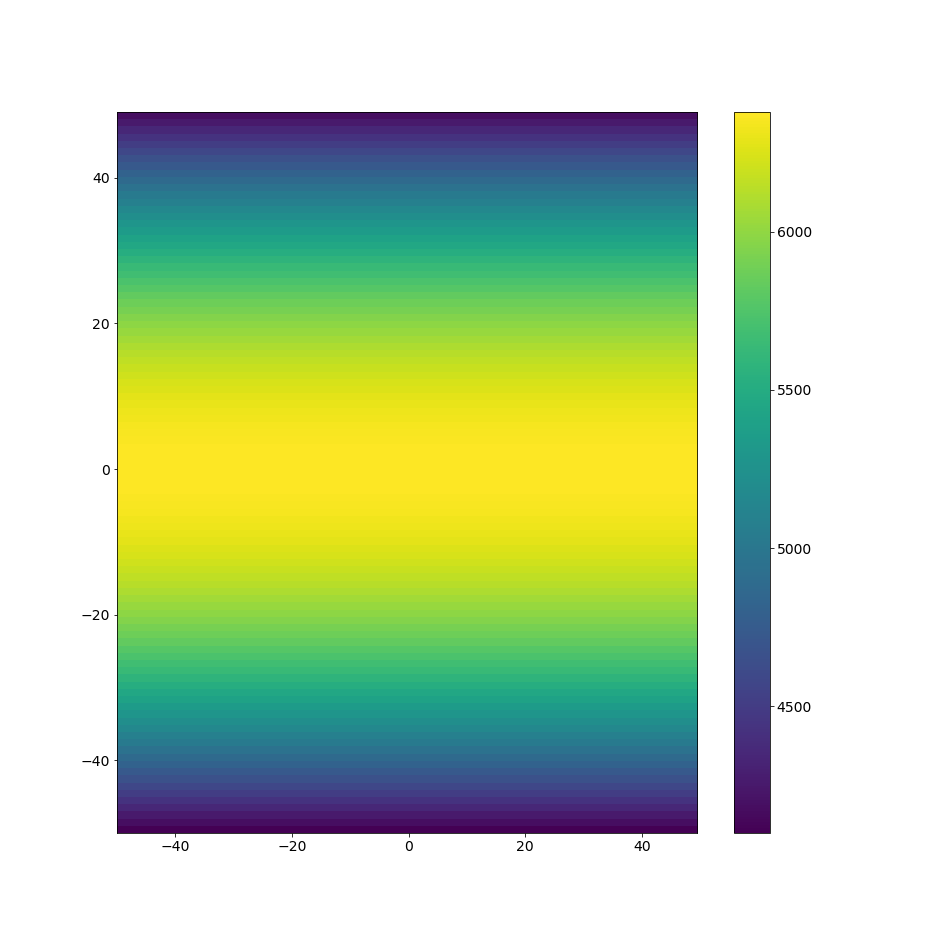

In [73]:
fig, ax = plt.subplots(1,1)
p = ax.pcolorfast(lons, lats, cell_areas.T*1e-6)
fig.colorbar(p)

In [62]:
(R_E + H_IONO_BOT)*D2R*2

225880.51179310612